In [ ]:
%%time
#@title install
#@markdown install ESMFold, OpenFold and download Params (~2min 30s)
version = "1" #
model_name = "esmfold_v0.model" if version == "0" else "esmfold.model"
import os, time
if not os.path.isfile(model_name):
  # download esmfold params
  os.system("apt-get install aria2 -qq")
  os.system(f"aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/{model_name} &")

  if not os.path.isfile("finished_install"):
    # install libs
    print("installing libs...")
    os.system("pip install -q omegaconf pytorch_lightning biopython ml_collections einops py3Dmol modelcif")
    os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")

    print("installing openfold...")
    # install openfold
    os.system(f"pip install -q git+https://github.com/sokrypton/openfold.git")

    print("installing esmfold...")
    # install esmfold
    os.system(f"pip install -q git+https://github.com/sokrypton/esm.git")
    os.system("touch finished_install")

  # wait for Params to finish downloading...
  while not os.path.isfile(model_name):
    time.sleep(5)
  if os.path.isfile(f"{model_name}.aria2"):
    print("downloading params...")
  while os.path.isfile(f"{model_name}.aria2"):
    time.sleep(5)

installing libs...
installing openfold...
installing esmfold...
CPU times: user 849 ms, sys: 148 ms, total: 997 ms
Wall time: 3min 56s


In [ ]:
%%time
#@title Set the environment and connect to google drive
# @markdown It will ask for access permissions

# import libs
from pydrive2.drive import GoogleDrive
from pydrive2.auth import GoogleAuth
from google.colab import auth
from oauth2client.client import GoogleCredentials
from tqdm import tqdm
import pandas as pd
import plotly.express as px
from google.colab import files

# google drive login
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

CPU times: user 962 ms, sys: 118 ms, total: 1.08 s
Wall time: 42.9 s


In [ ]:
%%time
#@title Set directory in google drive to save the PDBs
#@markdown You have to create it in your google drive session

# get the name of the dir
folder_id = 'esmfold' #@param {type:"string"}
file_list = drive.ListFile({'q': "mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()
for file in file_list:
    if file['title'] == folder_id:
        folder_id = file['id']
        break

CPU times: user 74.8 ms, sys: 2.33 ms, total: 77.1 ms
Wall time: 1.17 s


In [ ]:
#@title ##import libs and set functions
%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

CPU times: user 1.92 s, sys: 320 ms, total: 2.24 s
Wall time: 2.21 s


In [ ]:
#@title ##load your csv with names and sequences as columns
%%time
from google.colab import files
import os

# Crear un botón para subir archivos
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
os.rename(file_name, 'data.csv')

df = pd.read_csv("data.csv",sep="\t", names=["protein_name","seq"])

print("\n########## Data example ##########")
for idx, row in df.head(3).iterrows():
  protein_name = row["protein_name"]
  print(protein_name)
  seq = row["seq"]
  print(seq)

Saving all_cdds_reformated_nogap_seqid.csv to all_cdds_reformated_nogap_seqid.csv

########## Data example ##########
seq_0
DPLEWTPEHVQQWLSWVSKKFSLDPIDPDRFPMNGKELCALSKEDFRERAPSRGGDVLASHLALLRK
seq_1
QPIYWSRDDVAQWLKWAENEFSLRPIDSNTFEMNGKALLLLTKEDFRYRSPHSGDRLYELLQHILK
seq_2
DPRQWTETHVRDWVMWAVNEFSLKGVDFQKFCMSGAALCALGKECFLELAPDFVGDILWEHLEILQK
CPU times: user 49.3 ms, sys: 8.44 ms, total: 57.7 ms
Wall time: 7.26 s


In [ ]:
#@title ##Run ESMFold
%%time

model_lst = []
plddt_lst = []
ptm_lst = []
length_lst = []

print("Performing structure prediction with ESMFold v1")
pbar = tqdm(total=len(df), )

for idx, row in df.iterrows():

  protein_name = str(row["protein_name"])
  seq = str(row["seq"])
  jobname = protein_name
  jobname = re.sub(r'\W+', '', jobname)[:50]
  sequence = seq

  sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
  sequence = re.sub(":+",":",sequence)
  sequence = re.sub("^[:]+","",sequence)
  sequence = re.sub("[:]+$","",sequence)
  copies = 1
  if copies == "" or copies <= 0: copies = 1
  sequence = ":".join([sequence] * copies)
  num_recycles = 3
  chain_linker = 25

  ID = jobname+"_"+get_hash(sequence)[:5]
  seqs = sequence.split(":")
  lengths = [len(s) for s in seqs]
  length = sum(lengths)
  # print("length",length)

  u_seqs = list(set(seqs))
  if len(seqs) == 1: mode = "mono"
  elif len(u_seqs) == 1: mode = "homo"
  else: mode = "hetero"

  if "model" not in dir() or model_name != model_name_:
    if "model" in dir():
      # delete old model from memory
      del model
      gc.collect()
      if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model = torch.load(model_name)
    model.eval().cuda().requires_grad_(False)
    model_name_ = model_name

  # optimized for Tesla T4
  if length > 700:
    model.set_chunk_size(64)
  else:
    model.set_chunk_size(128)

  torch.cuda.empty_cache()
  output = model.infer(sequence,
                       num_recycles=num_recycles,
                       chain_linker="X"*chain_linker,
                       residue_index_offset=512)

  pdb_str = model.output_to_pdb(output)[0]
  output = tree_map(lambda x: x.cpu().numpy(), output)
  ptm = output["ptm"][0]
  plddt = output["plddt"][0,...,1].mean()
  O = parse_output(output)
  #print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
  #os.system(f"mkdir -p {ID}")
  #prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
  #np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
  with open(f"{protein_name}.pdb","w") as out:
    out.write(pdb_str)

  model_lst.append(jobname)
  ptm_lst.append(ptm)
  plddt_lst.append(plddt)
  length_lst.append(length)

  # upload the results to google drive
  uploaded = drive.CreateFile({'title': f"{protein_name}.pdb", 'parents': [{'id': folder_id}]})
  uploaded.SetContentFile(f"{protein_name}.pdb")
  uploaded.Upload()
  # update the progress bar
  pbar.update(1)
pbar.close()

Performing structure prediction with ESMFoldv1


100%|██████████| 1339/1339 [1:18:01<00:00,  3.50s/it]

CPU times: user 37min, sys: 20.2 s, total: 37min 20s
Wall time: 1h 18min 1s


In [ ]:
#@title Plot the quality of the models

# create the csv
dfq = pd.DataFrame()
dfq["model"] = model_lst
dfq["plddt"] = plddt_lst
dfq["ptm"] = ptm_lst

# plot
fig = px.histogram(dfq, x="model", y="plddt", title='Model quality', height = 600, width = 800, hover_name="model")
fig.update_traces(marker=dict(color = "red", size=8, line=dict(width=1, color='black')),selector=dict(mode='markers'))
fig.update_layout(template="plotly_white")
fig.update_yaxes(showline=True, linewidth=1, linecolor='LightGrey')
fig.update_xaxes(showline=True, linewidth=1, linecolor='LightGrey')
fig.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


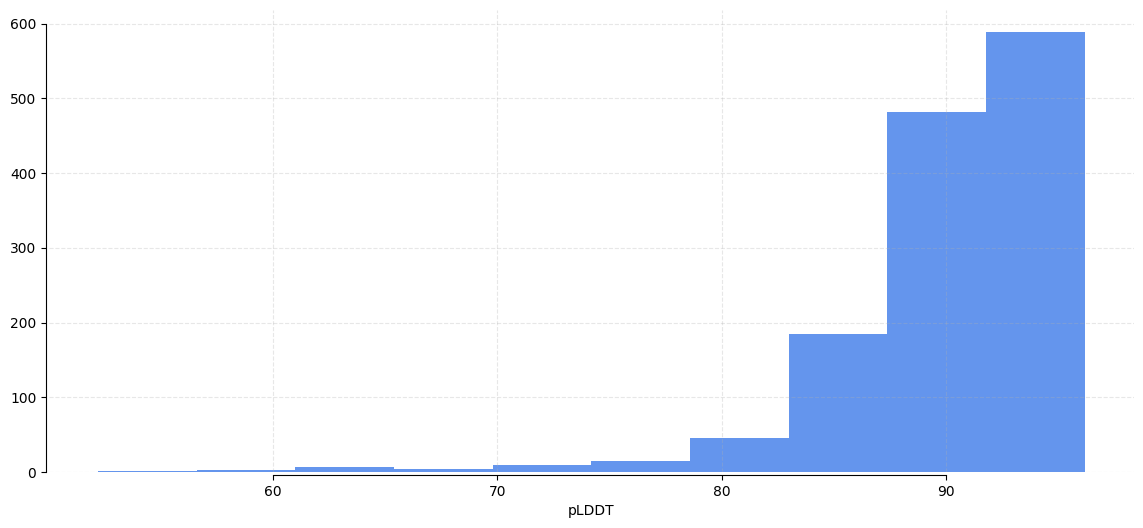

In [ ]:
plt.figure(figsize=(14,6))
plt.hist(dfq.plddt, color="cornflowerblue")
plt.grid(alpha=0.3, linestyle="--")
plt.xlabel("pLDDT")
sns.despine(trim=True, offset=2)

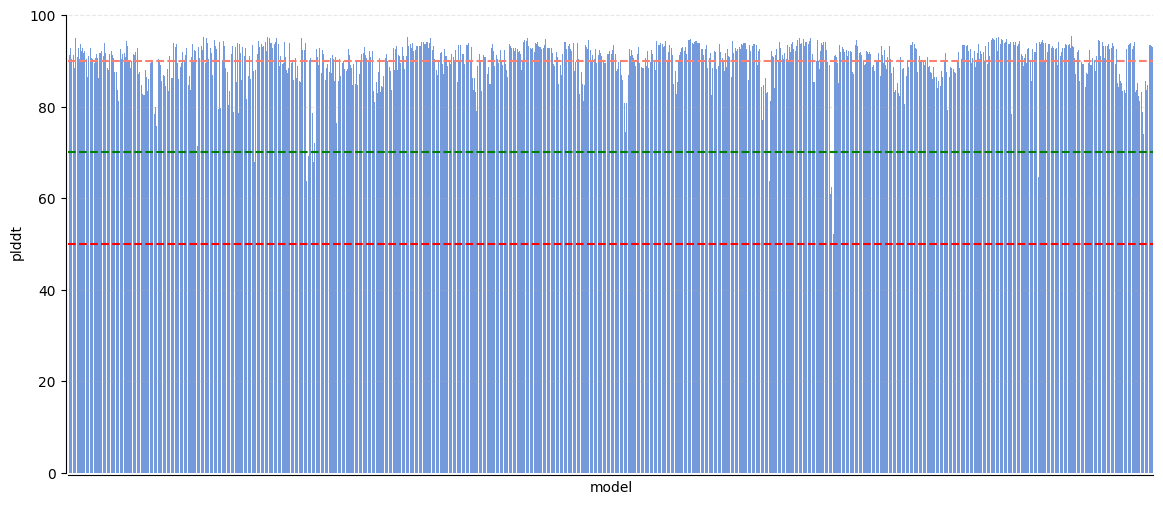

In [ ]:
plt.figure(figsize=(14,6))
sns.barplot(data=dfq, x="model", y="plddt", color="cornflowerblue")
plt.axhline(y=90, color='salmon', linestyle='--')
plt.axhline(y=70, color='green', linestyle='--')
plt.axhline(y=50, color='red', linestyle='--')
plt.xticks([])
plt.grid(alpha=0.3, linestyle="--")
sns.despine(trim=True, offset=2)

In [ ]:
dfq.to_csv("ESMFold_predictions_metrics.csv", index=False)

In [ ]:
dfq

,model,plddt,ptm
0,seq_0,93.472916,0.842306
1,seq_1,91.213898,0.822487
2,seq_2,92.892601,0.824586
3,seq_3,90.345421,0.809937
4,seq_4,91.548141,0.813983
...,...,...,...
1334,seq_1334,93.387581,0.841622
1335,seq_1335,93.500023,0.840881
1336,seq_1336,93.227921,0.842094
1337,seq_1337,93.127243,0.834942
